# Datathon Mayo 2018  **_"Haciendo el gasto fiscal visible para el público"_**
## Gasto Neto Mensualizado por año de las Instituciones Públicas

## Lectura de Datos

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import datetime as dt
# import pandas_profiling as pd_profiling
import altair as alt

alt.data_transformers.enable('json')
# alt.data_transformers.enable('default', max_rows=10000)

DataTransformerRegistry.enable('json')

In [2]:
def read_field_type(x):
    '''
    Para facilitar la lectura de los dataframes con los tipos de columna correspondientes.
    '''
    if x in ['String']:
        return str
    elif x in ['Integer', 'Long']:
        return int
    else:
        return str

In [3]:
pub_spend_names = pd.read_csv(os.path.join('data', 
                              'dataset_1_monthly_spend_2009-2017_DICTIONARY.csv'), 
                              sep=';', 
                              encoding='utf-8')

In [4]:
pub_spend_names

,Field name,Field type,Field size,Field format,Range,Description,Example
0,Periodo,Integer,15,#,2009 to 2017,Year of the spend,2009
1,Nombre Partida,String,63,NaN,28 categories,Ministeries,Ministerio de Educación
2,Nombre Capitulo,String,78,NaN,219 categories,Public Services,Fondo Nacional de Salud
3,Nombre Programa,String,78,NaN,363 categories,Programs,Fondo Nacional de Salud
4,Nombre Subtitulo,String,37,NaN,10 categories,First level of the budget classification,TRANSFERENCIAS CORRIENTES
5,Nombre Item,String,54,NaN,43 categories,Second level of the budget classification,Al Sector Privado
6,Nombre Asignación,String,250,NaN,4372 categories,Third level of the budget classification,Subsidios Fondo Solidario de Vivienda
7,Nombre SubAsignación,String,80,NaN,1355 categories,Last level of the budget classification,Asistencia Técnica
8,Mes,String,10,NaN,12 categories,Month,enero
9,Monto,Integer,15,#,(-49702217) to 357607483,"Amount, this data was update by the inflation ...",357607483


In [5]:
pub_spend_names.iloc[9, 5]

"Amount, this data was update by the inflation factors, and it's expressed in thousands of pesos"

In [6]:
pub_spend = pd.read_csv(os.path.join('data', 
                              'dataset_1_monthly_spend_2009-2017.csv'),
                 sep=';', 
                 encoding='utf-8',
                 dtype=dict(zip(pub_spend_names['Field name'], pub_spend_names['Field type'].apply(read_field_type))))

In [7]:
pub_spend.head(5) 

,Periodo,Nombre Partida,Nombre Capitulo,Nombre Programa,Nombre Subtitulo,Nombre Item,Nombre Asignación,Nombre SubAsignación,Mes,Monto_sum
0,2009,Congreso Nacional,Biblioteca Del Congreso,Biblioteca Del Congreso,INICIATIVAS DE INVERSIÓN,Proyectos,Gastos Administrativos,NaN,Abril,0
1,2009,Congreso Nacional,Biblioteca Del Congreso,Biblioteca Del Congreso,INICIATIVAS DE INVERSIÓN,Proyectos,Gastos Administrativos,NaN,Agosto,0
2,2009,Congreso Nacional,Biblioteca Del Congreso,Biblioteca Del Congreso,INICIATIVAS DE INVERSIÓN,Proyectos,Gastos Administrativos,NaN,Diciembre,0
3,2009,Congreso Nacional,Biblioteca Del Congreso,Biblioteca Del Congreso,INICIATIVAS DE INVERSIÓN,Proyectos,Gastos Administrativos,NaN,Enero,0
4,2009,Congreso Nacional,Biblioteca Del Congreso,Biblioteca Del Congreso,INICIATIVAS DE INVERSIÓN,Proyectos,Gastos Administrativos,NaN,Febrero,0


In [8]:
pub_spend.columns = ['periodo', 'partida', 'capitulo', 'programa', 'subtitulo', 'item', 'asignacion', 'subasignacion', 'mes', 'gasto']

In [9]:
pub_spend.shape

(3110448, 10)

In [10]:
pub_spend = pub_spend[pub_spend['gasto'] != 0]

In [11]:
pub_spend.shape

(2107310, 10)

In [12]:
def mbSize(obj):
    return round(sys.getsizeof(obj) / 1024.0 / 1024.0, 2)

mbSize(pub_spend)

1425.51

# Data Transformation

## Gasto anual

In [13]:
es_month_dict = {'enero': 1,
                 'febrero': 2,
                 'marzo': 3, 
                 'abril': 4,
                 'mayo': 5,
                 'junio': 6,
                 'julio': 7,
                 'agosto': 8,
                 'septiembre': 9,
                 'octubre': 10,
                 'noviembre': 11,
                 'diciembre': 12
                }

pub_spend['month'] = pub_spend['mes'].str.lower().map(es_month_dict)
pub_spend['day'] = 15
pub_spend['date'] = pd.to_datetime(pub_spend[['day', 'month', 'periodo']].rename(columns={'periodo': 'year'}))
pub_spend.drop(['periodo', 'mes', 'month', 'day'], axis=1, inplace=True)
pub_spend['gasto'] = pub_spend['gasto'] / 1000.0

## Aggregation data and JSON creation

In [14]:
ps_ministry = pub_spend.groupby(['date', 'partida'])['gasto'].sum().reset_index()
ps_ministry_dict = alt.to_json(ps_ministry, prefix='ps_ministry')
print('Memoria utilizada: {} mb'.format(mbSize(ps_ministry)))

Memoria utilizada: 0.54 mb


In [15]:
ps_chapter = pub_spend.groupby(['date', 'capitulo'])['gasto'].sum().reset_index()
ps_chapter_dict = alt.to_json(ps_chapter, prefix='ps_chapter')
print('Memoria utilizada: {} mb'.format(mbSize(ps_chapter)))

Memoria utilizada: 4.8 mb


In [16]:
ps_ministry_chapter = pub_spend.groupby(['date', 'partida', 'capitulo'])['gasto'].sum().reset_index()
ps_ministry_chapter_dict = alt.to_json(ps_ministry_chapter, prefix='ps_ministry_chapter')
print('Memoria utilizada: {} mb'.format(mbSize(ps_ministry_chapter)))

Memoria utilizada: 8.42 mb


In [17]:
ps_ministry_chapter_subtitle = pub_spend.groupby(['date', 'partida', 'capitulo', 'subtitulo'])['gasto'].sum().reset_index()
ps_ministry_chapter_subtitle_dict = alt.to_json(ps_ministry_chapter_subtitle, prefix='ps_ministry_chapter_subtitle')
print('Memoria utilizada: {} mb'.format(mbSize(ps_ministry_chapter_subtitle)))

Memoria utilizada: 53.25 mb


In [18]:
# ps_ministry_chapter_subtitle_item = pub_spend.groupby(['date', 'partida', 'capitulo', 'subtitulo', 'item'])['gasto'].sum().reset_index()
# ps_ministry_chapter_subtitle_item_dict = alt.to_json(ps_ministry_chapter_subtitle_item, prefix='ps_ministry_chapter_subtitle_item')
# print('Memoria utilizada: {} mb'.format(mbSize(ps_ministry_chapter_subtitle_item)))

## Gasto Anual

In [19]:
pub_spend_base = alt.Chart().encode(
    x=alt.X('date:T', 
        timeUnit='year',
        axis=alt.Axis(title='Año'),
           ),
    y=alt.Y('sum(gasto):Q', 
            axis=alt.Axis(format="($,.2r", 
                          title='Millones de Pesos Chilenos')),
    tooltip=alt.Tooltip('sum(gasto):Q', 
                        format="($,.2r")
)

pub_spend_chart = alt.layer(
    pub_spend_base.mark_point(),
    pub_spend_base.mark_line(),
#     pub_spend_base.mark_text(dy=-10, dx=-5).encode(text=alt.Text('sum(gasto):Q', format="$.2s")), 
    data=ps_ministry_dict['url']
).properties(
    title='Gasto Anual',
    width=600, 
    height=400 
)

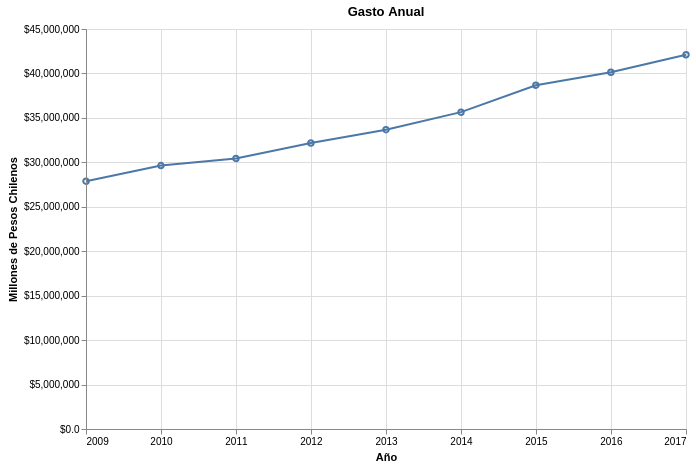

In [20]:
pub_spend_chart.save(os.path.join('charts', 'gastoAnual.json'))
pub_spend_chart

## Gasto Año-Mes

In [21]:
pub_spend_monthly_chart = alt.layer(
    pub_spend_base.mark_point().encode(
        x=alt.X('date:T', 
            timeUnit='yearmonth',
            axis=alt.Axis(title='Mes-Año')
            )
        ),
    pub_spend_base.mark_line().encode(
        x=alt.X('date:T', 
            timeUnit='yearmonth',
            axis=alt.Axis(title='Mes-Año')
            )
        ),
#     pub_spend_base.mark_text(dy=-10, dx=-5).encode(text=alt.Text('sum(gasto):Q', format="$.2s")), 
    data=ps_ministry_dict['url']
).properties(
    title='Gasto Mensual',
    width=600, 
    height=400 
)

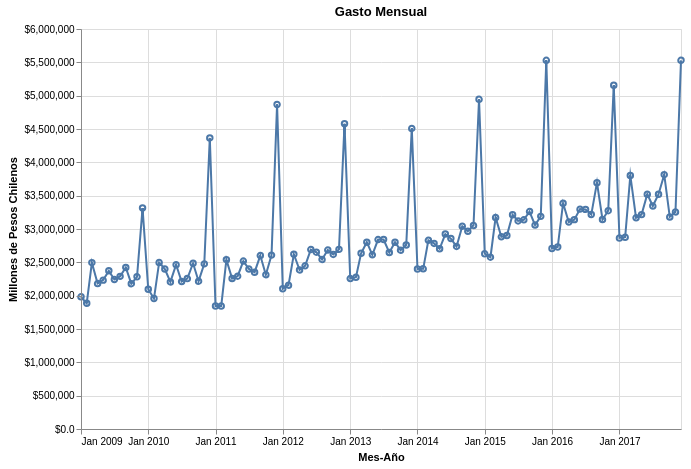

In [22]:
pub_spend_monthly_chart.save(os.path.join('charts', 'gastoMensual.json'))
pub_spend_monthly_chart

## Gasto Promedio Anual por Partida

In [23]:
from altair import datum

In [24]:
gasto_promedio_anual_partida = ps_ministry_chapter.groupby(['partida', pd.Grouper(key='date', freq='1Y')])['gasto'].sum().groupby(level=0).mean().sort_values(ascending=False).reset_index()
gasto_promedio_anual_partida_dict = alt.to_json(gasto_promedio_anual_partida, prefix='gasto_promedio_anual_partida')
print('Memoria utilizada: {} mb'.format(mbSize(gasto_promedio_anual_partida)))

Memoria utilizada: 0.01 mb


In [25]:
ministry_mean_pub_spend = alt.Chart(gasto_promedio_anual_partida_dict['url']).mark_bar().encode(
    x=alt.X('sum(gasto):Q', 
            axis=alt.Axis(format="($,.2r", 
                          title='Millones de Pesos Chilenos')
           ),
    y=alt.Y('partida:N', 
            axis=alt.Axis(title='Partida')
           ),
    tooltip=alt.Tooltip('sum(gasto):Q', 
                        format="($,.2r"
                       )
).properties(
    title='Gasto Promedio Anual por Partida',
    width=700, 
    height=700 
)

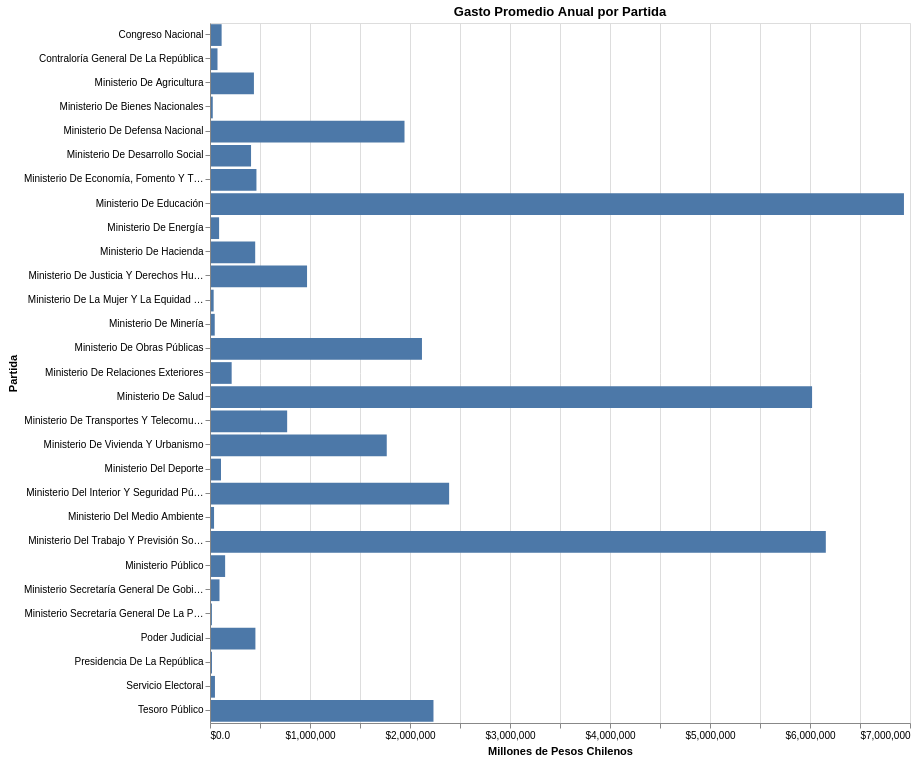

In [26]:
ministry_mean_pub_spend.save(os.path.join('charts', 'gastoPromedioAnualPartida.json'))
ministry_mean_pub_spend

## Gasto Anual por Partida

In [27]:
# Base mark and encoding
pub_spend_ministry_base_layer = alt.Chart().encode(
    x=alt.X('date:T', 
        timeUnit='year',
        axis=alt.Axis(title='Año')
           ),
    y=alt.Y('sum(gasto):Q', 
            axis=alt.Axis(format="($,.2r", 
                          title='Millones de Pesos Chilenos')
           ),
    tooltip='partida:N'
)

# Highlight
pub_spend_ministry_highlight = alt.selection(type='single', on='mouseover',
                          fields=['partida'], nearest=True)

# Layered chart
pub_spend_ministry_layer = alt.layer(
    pub_spend_ministry_base_layer.mark_line(strokeWidth=2.5).encode(
        color=alt.Color('partida:N', 
                        scale=None, 
                        title=None
                       ),
        size=alt.condition(~pub_spend_ministry_highlight, 
                           alt.value(1), 
                           alt.value(3)
                          ),
    ),
    pub_spend_ministry_base_layer.mark_line(strokeWidth=2.5).encode(
        color=alt.Color('partida:N', 
                        title='Partida'
                       ),
        size=alt.condition(~pub_spend_ministry_highlight, 
                           alt.value(1), 
                           alt.value(3)
                          ),
    ).transform_filter(
        (datum.partida == gasto_promedio_anual_partida.iloc[0, 0]) | \
        (datum.partida == gasto_promedio_anual_partida.iloc[1, 0]) | \
        (datum.partida == gasto_promedio_anual_partida.iloc[2, 0])
    ),
    pub_spend_ministry_base_layer.mark_circle().encode(
        opacity=alt.value(0)
    ).properties(
        selection=pub_spend_ministry_highlight,
    ),
    data=ps_ministry_dict['url']
).properties(
    title='Gasto Anual por Partida',
    width=600, 
    height=400 
).encode(tooltip='partida:N')

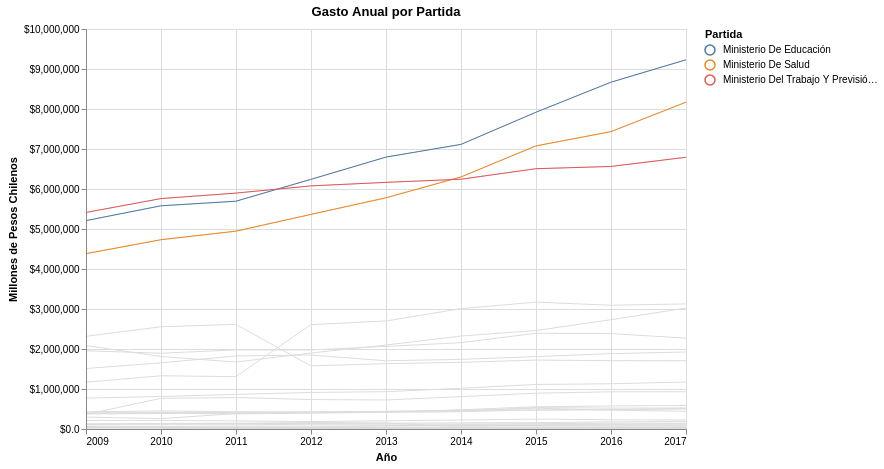

In [28]:
pub_spend_ministry_layer.save(os.path.join('charts', 'gastoAnualPorPartida.json'))
pub_spend_ministry_layer

## Gasto Anual por Capitulo

In [29]:
gasto_promedio_anual_partida_capitulo = ps_ministry_chapter.groupby(['capitulo', pd.Grouper(key='date', freq='1Y')])['gasto'].sum().groupby(level=0).mean().sort_values(ascending=False).reset_index()

In [30]:
# Base mark and encoding
pub_spend_ministry_chapter_base_layer = alt.Chart().encode(
    x=alt.X('date:T', 
        timeUnit='year',
        axis=alt.Axis(title='Año')
           ),
    y=alt.Y('sum(gasto):Q', 
            axis=alt.Axis(format="($,.2r", 
                          title='Millones de Pesos Chilenos')
           ),
    tooltip='capitulo:N'
)

# Highlight
pub_spend_ministry_chapter_highlight = alt.selection(type='single', on='mouseover',
                          fields=['capitulo'], nearest=True)

# Layered chart
pub_spend_ministry_chapter_layer = alt.layer(
    pub_spend_ministry_chapter_base_layer.mark_line(strokeWidth=2.5).encode(
        color=alt.Color('capitulo:N', 
                        scale=None, 
                        title=None
                       ),
        size=alt.condition(~pub_spend_ministry_chapter_highlight, 
                           alt.value(1), 
                           alt.value(3)
                          ),
    ),
    pub_spend_ministry_chapter_base_layer.mark_line(strokeWidth=2.5).encode(
        color=alt.Color('capitulo:N', 
                        title='Capítulo'
                       ),
        size=alt.condition(~pub_spend_ministry_chapter_highlight, 
                           alt.value(1), 
                           alt.value(3)
                          ),
    ).transform_filter(
        (datum.capitulo == gasto_promedio_anual_partida_capitulo.iloc[0, 0]) | \
        (datum.capitulo == gasto_promedio_anual_partida_capitulo.iloc[1, 0]) | \
        (datum.capitulo == gasto_promedio_anual_partida_capitulo.iloc[2, 0]) | \
        (datum.capitulo == gasto_promedio_anual_partida_capitulo.iloc[3, 0])
    ),
    pub_spend_ministry_chapter_base_layer.mark_circle().encode(
        opacity=alt.value(0)
    ).properties(
        selection=pub_spend_ministry_chapter_highlight,
    ),
    data=ps_ministry_chapter_dict['url']
).properties(
    title='Gasto Anual por Capítulo',
    width=600, 
    height=400 
).encode(tooltip='capitulo:N')

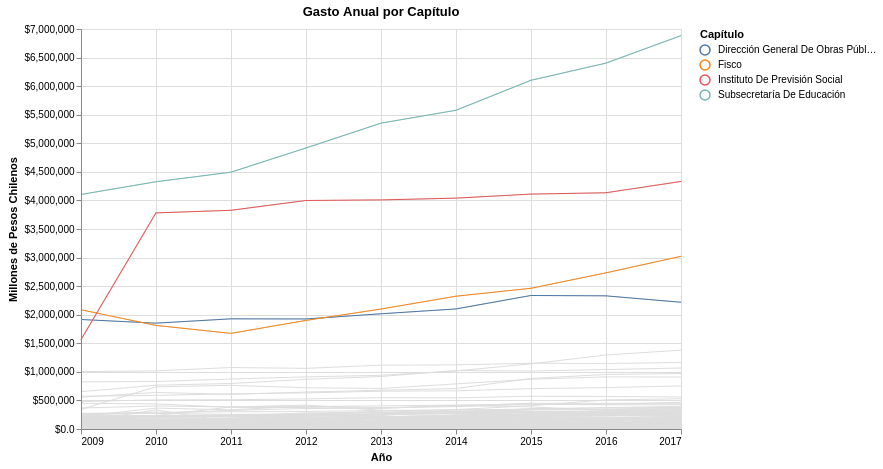

In [31]:
pub_spend_ministry_chapter_layer.save(os.path.join('charts', 'gastoAnualCapitulo.json'))
pub_spend_ministry_chapter_layer

## Por subtítulo

In [32]:
pub_spend_agg2_how = pub_spend.groupby(['partida', 'subtitulo', 'item', 'date'])['gasto'].sum().reset_index()

In [33]:
pub_spend_agg2_how_dict = alt.to_json(pub_spend_agg2_how, prefix='pub_spend_agg2_how')

In [34]:
ps_ministry_chapter_subtitle_dict

{'url': 'ps_ministry_chapter_subtitle-4c578cec-4681-4e80-bc79-134927cb693f.json',
 'format': {'type': 'json'}}

In [35]:
# Base mark and encoding
pub_spend_subtitle_base_layer = alt.Chart().encode(
    x=alt.X('date:T', 
        timeUnit='year',
        axis=alt.Axis(title='Año')
           ),
    y=alt.Y('sum(gasto):Q', 
            axis=alt.Axis(format="($,.2r", 
                          title='Millones de Pesos Chilenos')
           ),
    tooltip='subtitulo:N'
)

# Highlight
pub_spend_subtitle_highlight = alt.selection(type='single', on='mouseover',
                          fields=['subtitulo'], nearest=True)

# Layered chart
pub_spend_subtitle_layer = alt.layer(
    pub_spend_subtitle_base_layer.mark_line(strokeWidth=2.5).encode(
        color=alt.Color('subtitulo:N', 
                        title='Subtítulo'
                       ),
        size=alt.condition(~pub_spend_subtitle_highlight, 
                           alt.value(1), 
                           alt.value(3)
                          )
    ),
    pub_spend_subtitle_base_layer.mark_circle().encode(
        opacity=alt.value(0)
    ).properties(
        selection=pub_spend_subtitle_highlight,
    ),
    data=ps_ministry_chapter_subtitle_dict['url']
).properties(
    title='Gasto Anual por Subtítulo',
    width=600, 
    height=400 
).encode(tooltip='subtitulo:N')

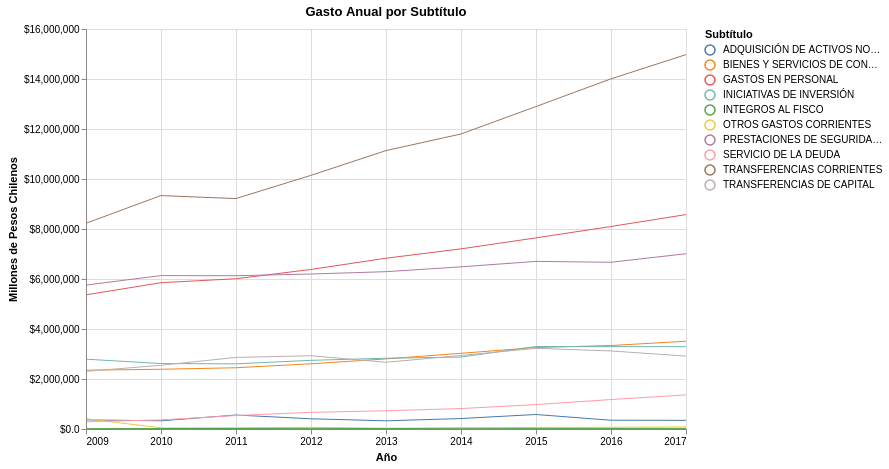

In [36]:
pub_spend_subtitle_layer.save(os.path.join('charts', 'gastoAnualSubtitulo.json'))
pub_spend_subtitle_layer

# Predicción

In [37]:
import itertools
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [38]:
ts = pub_spend.groupby(pd.Grouper(key='date', freq='1M'))['gasto'].sum().reset_index().set_index('date')

In [39]:
ts.head()

,gasto
date,
2009-01-31,1983148.607
2009-02-28,1884621.232
2009-03-31,2494693.436
2009-04-30,2182175.027
2009-05-31,2232954.923


In [40]:
np.random.seed(42)

In [41]:
ts = ts['gasto'].resample('MS').mean()
ts = ts.fillna(ts.bfill())

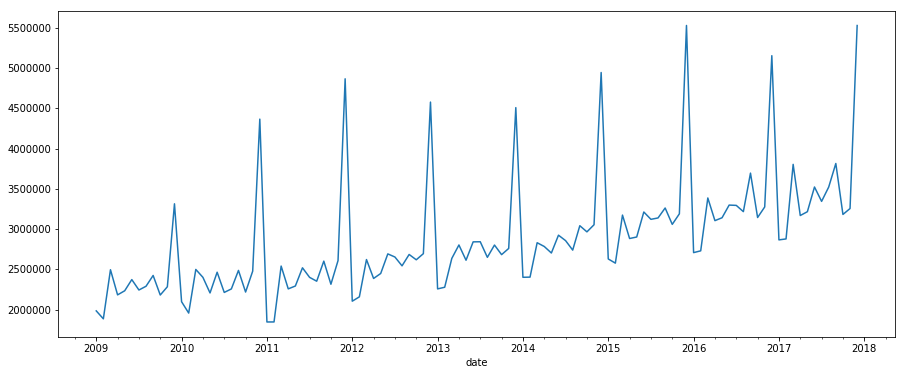

In [42]:
ts.plot(figsize=(15, 6))
plt.show()

In [43]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

In [44]:
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [45]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

info = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            

            print('ARIMA{}x{}12 - AIC:{} - BIC:{}'.format(param, param_seasonal, results.aic, results.bic))
            info.append((param, param_seasonal,results.aic, results.bic)) 
        
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3495.34343728014 - BIC:3498.016266114602
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3052.1684000990253 - BIC:3057.2761538822265
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2619.863554464298 - BIC:2622.4174313558983
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2272.5670504849236 - BIC:2277.404731700517
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2597.208459227472 - BIC:2602.3371556104075
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2579.827979603313 - BIC:2587.4896102781145
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2291.6207559038116 - BIC:2296.4823895014983
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2243.360194057181 - BIC:2250.616715880571
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3401.0623493478543 - BIC:3406.3892275360786
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2995.2162538938783 - BIC:3002.846138240688
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2583.7364991919235 - BIC:2588.8230887564637
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2238.3758076167555 - BIC:2245.5959653585483
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3

In [46]:
df_info = pd.DataFrame(info,columns = ["order","seasonal_order","AIC","BIC"])
df_info.head()

,order,seasonal_order,AIC,BIC
0,"(0, 0, 0)","(0, 0, 0, 12)",3495.343437,3498.016266
1,"(0, 0, 0)","(0, 0, 1, 12)",3052.168400,3057.276154
2,"(0, 0, 0)","(0, 1, 0, 12)",2619.863554,2622.417431
3,"(0, 0, 0)","(0, 1, 1, 12)",2272.567050,2277.404732
4,"(0, 0, 0)","(1, 0, 0, 12)",2597.208459,2602.337156


In [47]:
mask = df_info.AIC == df_info.AIC.min()
df_info[mask]

,order,seasonal_order,AIC,BIC
27,"(0, 1, 1)","(0, 1, 1, 12)",2182.735879,2189.919227


In [48]:
mask = df_info.BIC == df_info.BIC.min()
df_info[mask]

,order,seasonal_order,AIC,BIC
27,"(0, 1, 1)","(0, 1, 1, 12)",2182.735879,2189.919227


In [49]:
mod = sm.tsa.statespace.SARIMAX(ts,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8115      0.078    -10.408      0.000      -0.964      -0.659
ma.S.L12      -0.0070      0.078     -0.090      0.928      -0.160       0.146
sigma2      4.205e+10   1.71e-13   2.47e+23      0.000     4.2e+10     4.2e+10


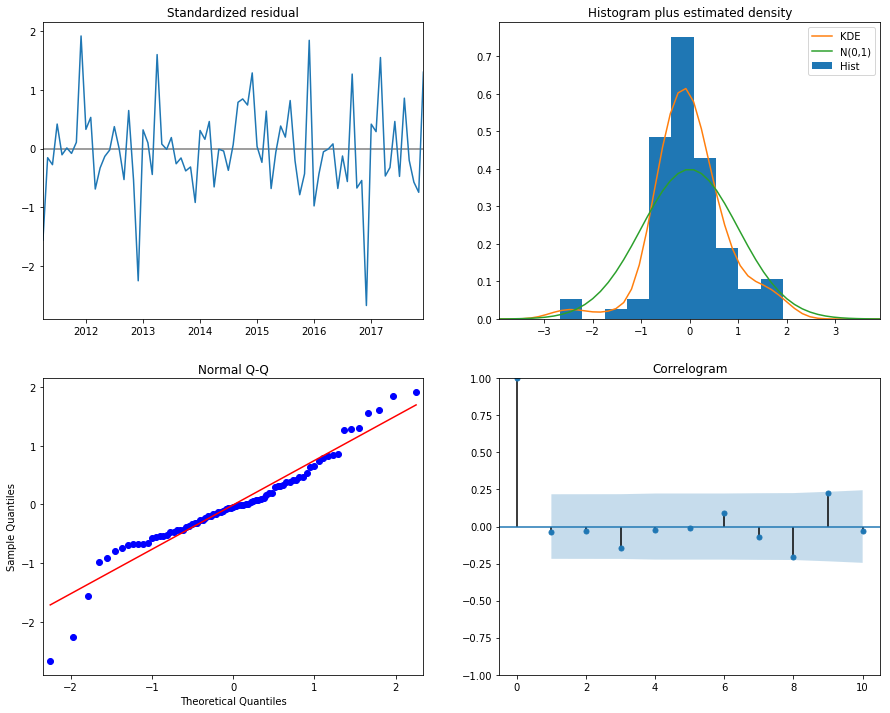

In [50]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [51]:
pred = results.get_prediction(start=ts.index[70], dynamic=False)
pred_ci = pred.conf_int()

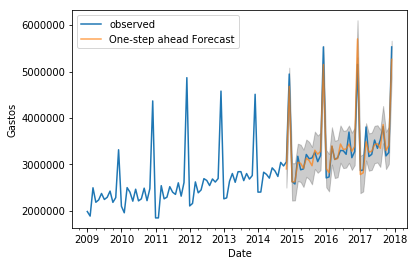

In [52]:
ax = ts['2009':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Gastos')
plt.legend()

plt.show()

In [53]:
ts_forecasted = pred.predicted_mean
ts_truth = ts['1998-01-01':]

# Compute the mean square error
mse = ((ts_forecasted - ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 29316257114.87


In [54]:
pred_dynamic = results.get_prediction(start=ts.index[70], dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

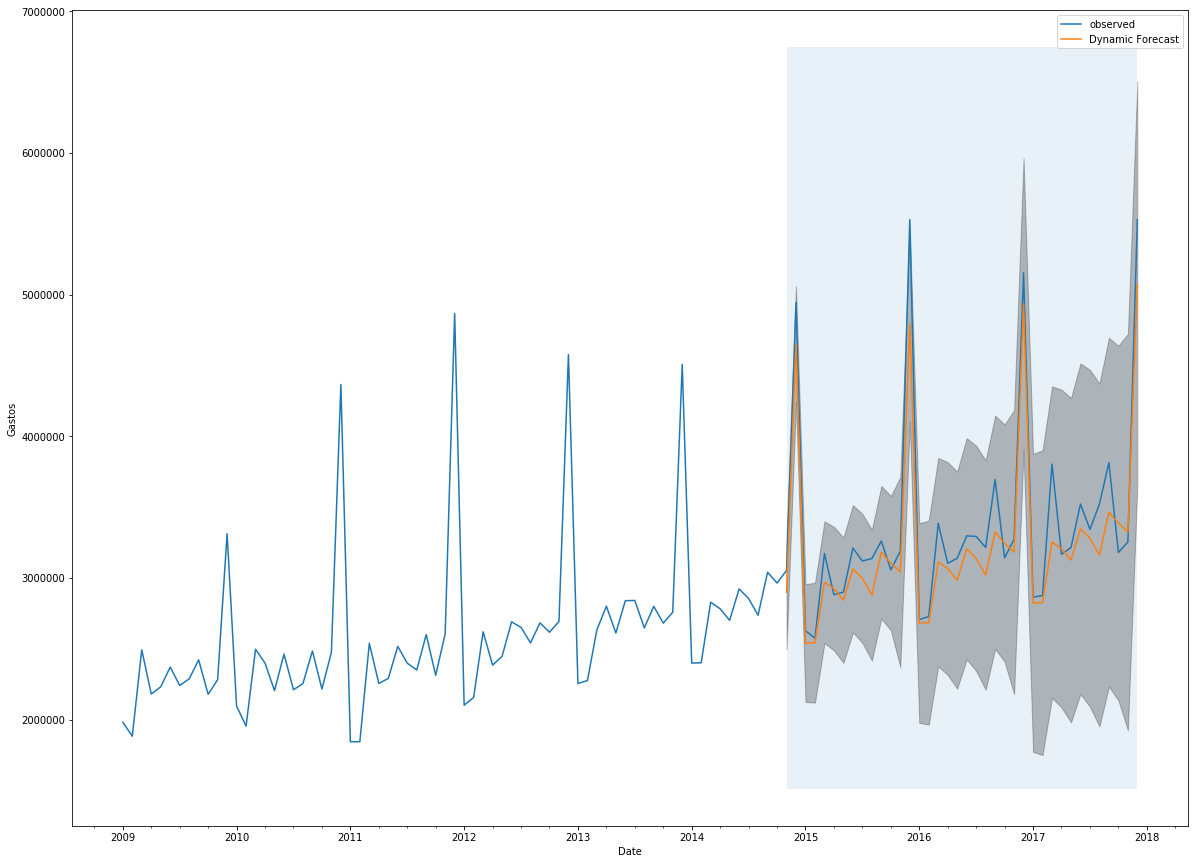

In [55]:
ax = ts['2009':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(),ts.index[70], ts.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Gastos')

plt.legend()
plt.show()

In [56]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=48)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

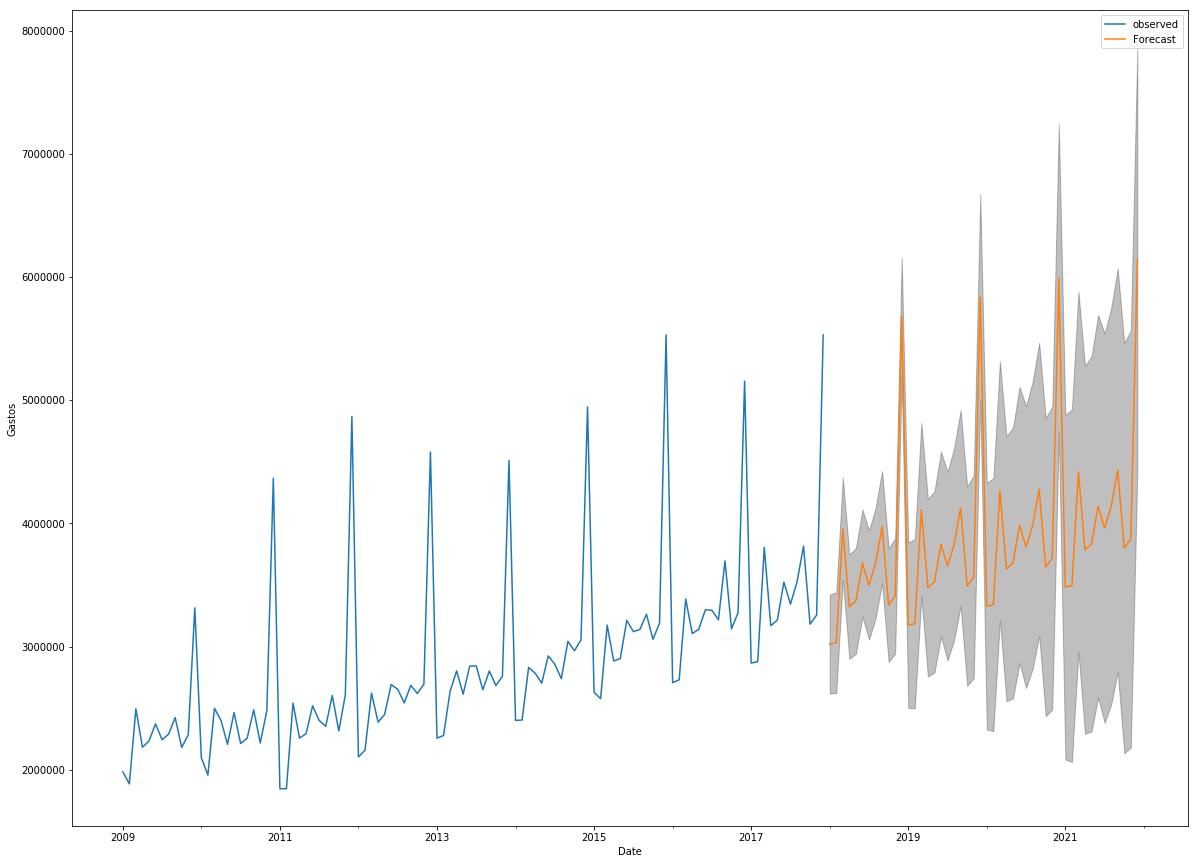

In [57]:
ax = ts['2009':].plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Gastos')

plt.legend()
plt.show()

In [58]:
df_temporal = ts.reset_index()

In [59]:
df_predict = pred_ci.assign(predict=pred_uc.predicted_mean)
df_predict = df_predict.reset_index()
df_predict.loc[48] = [df_temporal.loc[107,'date'],
                      df_temporal.loc[107,'gasto'],
                      df_temporal.loc[107,'gasto'],
                      df_temporal.loc[107,'gasto']]

In [60]:
df_predict.rename(columns={'index':'date'},inplace=True)
df_predict['date'] = df_predict['date'].astype('datetime64[ns]')

Graficar

In [61]:
df_predict_dict = alt.to_json(df_predict, prefix='forecastSpend.json')

In [62]:
line_predict = alt.Chart(df_predict_dict).mark_line(strokeDash = [3, 3]).encode(
    x=alt.X('date:T', 
            timeUnit='yearmonth',
            axis=alt.Axis(title='Mes-Año')
            ),
    y='predict:Q'
)

confidence_predict = alt.Chart(df_predict_dict).mark_area(opacity = 0.3).encode(
 x=alt.X('date:T', 
            timeUnit='yearmonth',
            axis=alt.Axis(title='Mes-Año')
            ),
 y  = 'lower gasto:Q',
 y2 = 'upper gasto:Q' ) 

spend_line = alt.Chart(ps_ministry_dict['url']).mark_line().encode(
    x=alt.X('date:T', 
        timeUnit='yearmonth',
        axis=alt.Axis(title='Mes-Año'),
           ),
    y=alt.Y('sum(gasto):Q', axis=alt.Axis(format="($,.2r", title='Millones de Pesos Chilenos'))
)

In [63]:
forecast_ps_monthly = alt.layer(
    spend_line,
    confidence_predict,
    line_predict
).properties(
    title='Predicción de Gasto Mensual',
    width=600, 
    height=400 
)

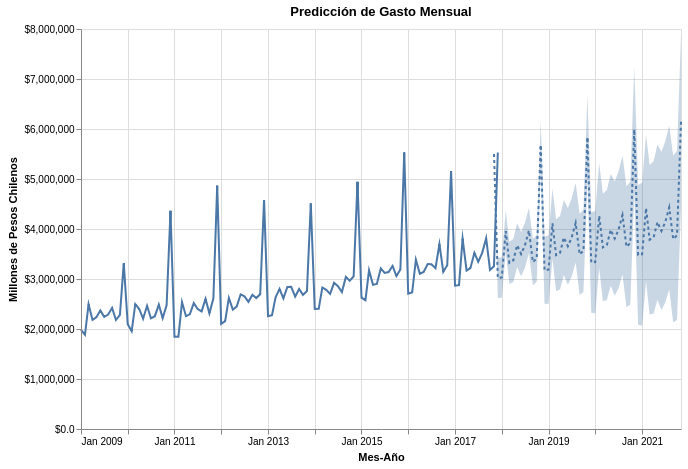

In [64]:
forecast_ps_monthly.save(os.path.join('charts', 'gastoMensualPred.json'))
forecast_ps_monthly

# Gastos Diciembre

In [65]:
gasto_promedio_anual_partida = pub_spend.groupby(['partida', pd.Grouper(key='date', freq='1m')])['gasto'].sum()
df_partida = pd.DataFrame({'gasto' : gasto_promedio_anual_partida}).reset_index()
df_partida.head()

,partida,date,gasto
0,Congreso Nacional,2009-01-31,11967.407
1,Congreso Nacional,2009-02-28,4863.919
2,Congreso Nacional,2009-03-31,9854.629
3,Congreso Nacional,2009-04-30,7156.741
4,Congreso Nacional,2009-05-31,7937.524


In [66]:
df_partida['date'] = df_partida['date'].astype(str)
df_partida["year"]  = df_partida["date"].apply(lambda x:x.split('-')[0] )
df_partida["month"] = df_partida["date"].apply(lambda x:x.split('-')[1] )
df_partida["day"]   = df_partida["date"].apply(lambda x:x.split('-')[2] )

In [67]:
partida_list = np.unique(df_partida['partida']).tolist()
year_list = np.unique(df_partida['year']).tolist()
aux_list = []
for partida in partida_list:
    df_p = df_partida[df_partida['partida'] == partida]
    for year in year_list:
        aux_df = df_p[df_p['year']==year]
        aux_df['percentage'] = aux_df['gasto']/aux_df['gasto'].sum()
        aux_list = aux_list + aux_df['percentage'].tolist()

In [68]:
# solo mes 12
df_partida['percentage_respect_year'] = aux_list
df_partida_12 = df_partida[df_partida['month'] == '12']

In [69]:
df_partida_12.head()

,partida,date,gasto,year,month,day,percentage_respect_year
11,Congreso Nacional,2009-12-31,13279.862,2009,12,31,0.125660
23,Congreso Nacional,2010-12-31,12769.237,2010,12,31,0.117450
35,Congreso Nacional,2011-12-31,11524.817,2011,12,31,0.108105
47,Congreso Nacional,2012-12-31,14729.433,2012,12,31,0.125755
59,Congreso Nacional,2013-12-31,11763.431,2013,12,31,0.098658


In [70]:
df_partida_12.groupby('partida')['percentage_respect_year'].mean()

partida
Congreso Nacional                                                  0.111395
Contraloría General De La República                                0.167376
Ministerio De Agricultura                                          0.176739
Ministerio De Bienes Nacionales                                    0.196740
Ministerio De Defensa Nacional                                     0.126188
Ministerio De Desarrollo Social                                    0.193309
Ministerio De Economía, Fomento Y Turismo                          0.246730
Ministerio De Educación                                            0.133075
Ministerio De Energía                                              0.227916
Ministerio De Hacienda                                             0.164237
Ministerio De Justicia Y Derechos Humanos                          0.132851
Ministerio De La Mujer Y La Equidad De Género                      0.144067
Ministerio De Minería                                              0.200201
Mini

In [71]:
partida_12 = alt.Chart(df_partida_12).mark_bar().encode(
    x=alt.X('mean(percentage_respect_year):Q', axis=alt.Axis(format=".0%", title='porcentaje')),
    y=alt.Y('partida:N', axis=alt.Axis(title='Partida')),
    tooltip=alt.Tooltip('mean(percentage_respect_year):Q', format=".2%")
).properties(
    title='Gasto promedio del mes de diciembre (porcentual respecto a cada año)',
    width=700, 
    height=700 
)

In [72]:
partida_12 = alt.Chart(df_partida_12).mark_bar().encode(
    x=alt.X('mean(percentage_respect_year):Q', axis=alt.Axis(format=".0%", title='porcentaje')),
    y=alt.Y('partida:N', axis=alt.Axis(title='Partida')),
    tooltip=alt.Tooltip('mean(percentage_respect_year):Q', format=".2%")
).properties(
    title='Gasto promedio del mes de diciembre (porcentual respecto a cada año)',
    width=700, 
    height=700 
)

In [73]:
df_partida_12_dict = alt.to_json(df_partida_12, prefix='procentaje_dec.json')

In [74]:
data2 = pd.DataFrame([{"ThresholdValue": 1.0/12.0, "Threshold": "porcentaje esperado"}])

In [75]:
bar1 = alt.Chart(df_partida_12_dict['url']).mark_bar().encode(
    x=alt.X('mean(percentage_respect_year):Q', axis=alt.Axis(format=".0%", title='Porcentaje Gasto Anual Promedio')),
    y=alt.Y('partida:N', axis=alt.Axis(title='Partida')),
    tooltip=alt.Tooltip('mean(percentage_respect_year):Q', format=".2%")
).properties(
    title='Gasto Porcentual Promedio de Diciembre por Partida',
    width=700, 
    height=700 
)

bar2 = alt.Chart(df_partida_12_dict['url']).mark_bar(color="#e45755").encode(
    x='mean(percentage_respect_year):Q',
    x2='baseline:Q',
    y='partida:N',
    tooltip=alt.Tooltip('mean(percentage_respect_year):Q', format=".2%")
).transform_calculate(
    "baseline", "0.0833"
)

rule = alt.Chart(data2).mark_rule().encode(
    x='ThresholdValue:Q'
)

text = alt.Chart(data2).mark_text(
    align='center', dx=215, dy=-5
).encode(
    alt.X('ThresholdValue:Q', axis=alt.Axis(title='porcentaje')),
    text=alt.value('porcentaje esperado')
)

december_perc_chart = alt.layer(
    bar1,
    bar2,
    rule
)

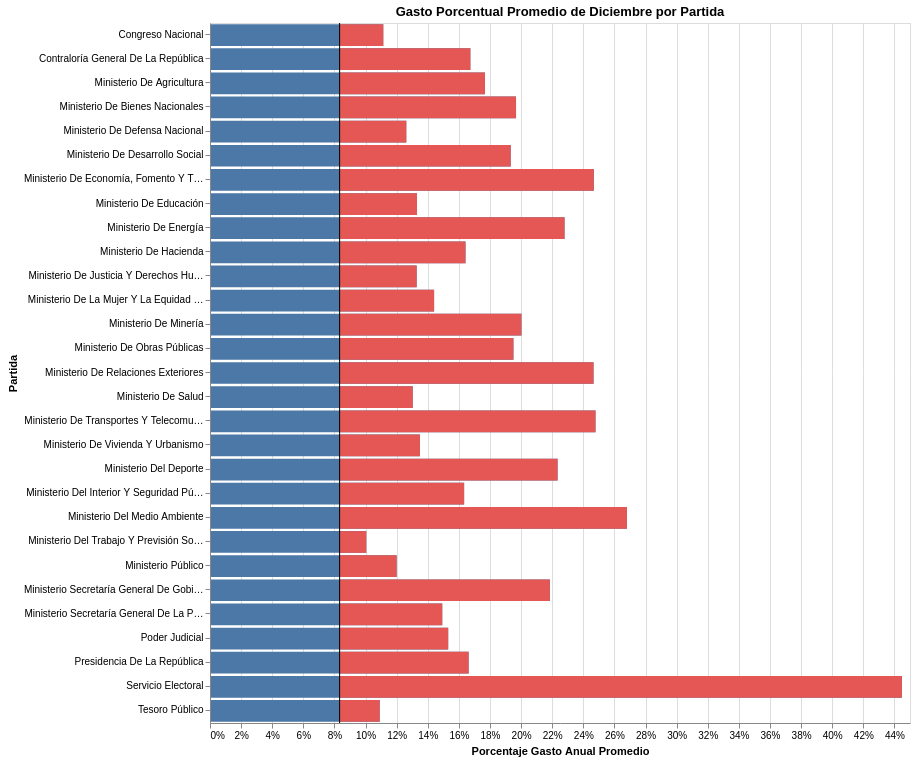

In [76]:
december_perc_chart.save(os.path.join('charts', 'gastoPromedioDec.json'))
december_perc_chart